# Environment

In [1]:
import os
import io
import time
import requests
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# clone the git repository and set it as the working directory
! git clone https://github.com/martin-marek/parking-space-occupancy
os.chdir('parking-space-occupancy')

Cloning into 'parking-space-occupancy'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 86 (delta 18), reused 17 (delta 17), pack-reused 60 (from 1)
Receiving objects: 100% (86/86), 3.58 MiB | 7.06 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
# download the dataset
if not os.path.exists('dataset/data'):
    r = requests.get("https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2Frois_gopro.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('dataset/data')

# Visualize dataset

In [4]:
from dataset import acpds
from utils import transforms
from utils import visualize as vis

In [5]:
train_ds, valid_ds, test_ds = acpds.create_datasets('dataset/data')

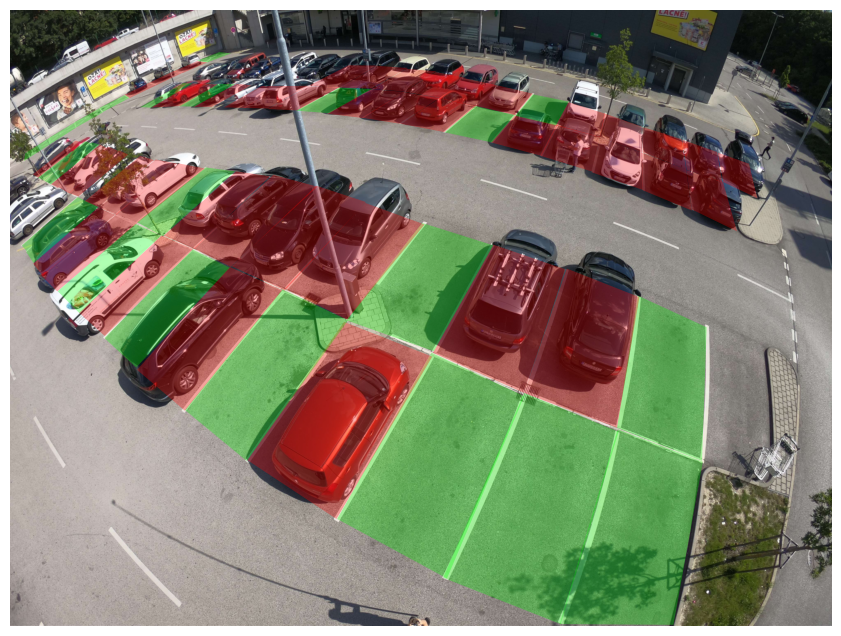

In [6]:
image_batch, rois_batch, labels_batch = next(iter(valid_ds))
image_raw, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
image = transforms.preprocess(image_raw, res=1440)
vis.plot_ds_image(image, rois, labels, show=True)

# Plot model predictions

In [10]:
# create model
from models.rcnn import RCNN
model = RCNN()

# load model weights
weights_path = 'weights.pt'
if not os.path.exists(weights_path):
    r = requests.get('https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2FRCNN_128_square_gopro.pt')
    with open(weights_path, 'wb') as f:
        f.write(r.content)
model.load_state_dict(torch.load(weights_path, map_location='cpu'))

<All keys matched successfully>

torch.Size([3, 3000, 4000])
torch.Size([76])


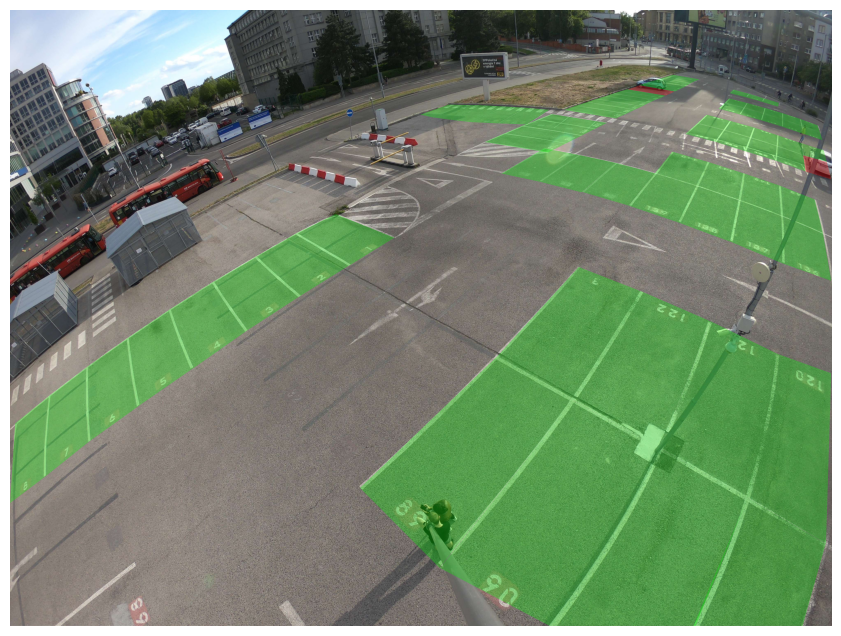

torch.Size([3, 3000, 4000])
torch.Size([41])


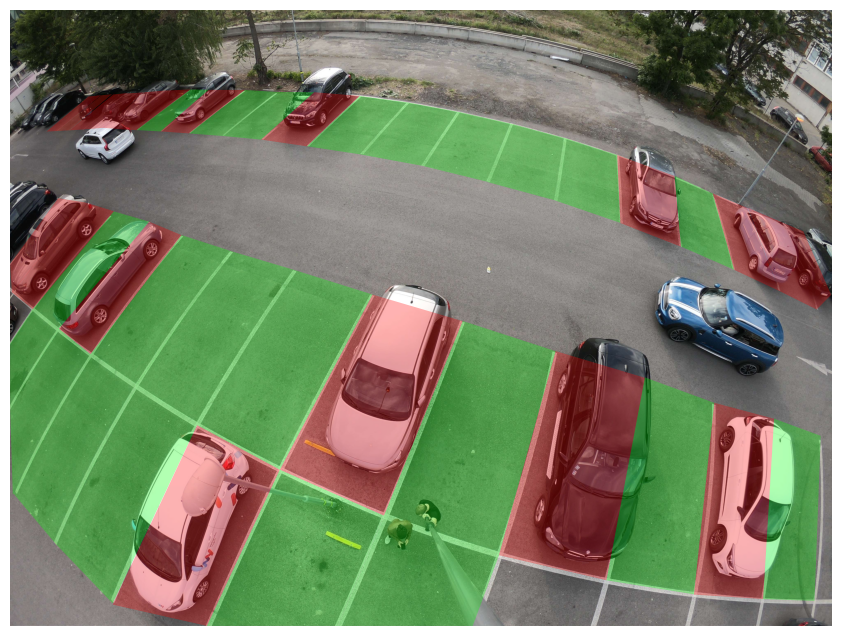

In [24]:
# plot test predictions
for i, (image_batch, rois_batch, labels_batch) in enumerate(test_ds):
    if i == 2: break
    image, rois, labels = image_batch[0], rois_batch[0], labels_batch[0]
    # print(image)
    image = transforms.preprocess(image)
    print(image.shape)
    with torch.no_grad():
        class_logits = model(image, rois)
        class_scores = class_logits.softmax(1)[:, 1]

    print(class_scores.shape)

    vis.plot_ds_image(image, rois, class_scores)

In [26]:
print(rois)

tensor([[[0.2278, 0.6737],
         [0.1531, 0.6094],
         [0.2689, 0.3914],
         [0.3469, 0.4224]],

        [[0.3286, 0.7464],
         [0.2276, 0.6740],
         [0.3469, 0.4223],
         [0.4414, 0.4619]],

        [[0.4553, 0.8210],
         [0.3285, 0.7464],
         [0.4414, 0.4620],
         [0.5512, 0.5051]],

        [[0.5954, 0.8851],
         [0.4552, 0.8213],
         [0.5513, 0.5049],
         [0.6645, 0.5539]],

        [[0.7263, 0.9259],
         [0.5953, 0.8852],
         [0.6643, 0.5537],
         [0.7733, 0.5972]],

        [[0.8329, 0.9487],
         [0.7263, 0.9260],
         [0.7730, 0.5964],
         [0.8577, 0.6378]],

        [[0.9172, 0.9564],
         [0.8328, 0.9492],
         [0.8576, 0.6377],
         [0.9305, 0.6636]],

        [[0.9796, 0.9593],
         [0.9170, 0.9565],
         [0.9304, 0.6635],
         [0.9872, 0.6913]],

        [[0.0551, 0.8662],
         [0.0040, 0.7848],
         [0.0985, 0.5595],
         [0.1534, 0.6090]],

        [[

torch.Size([49]) torch.Size([49, 4, 2])
tensor(5.9786e-10) tensor(1.9698e-08) tensor(2.5427e-08) tensor(7.0028e-08) tensor(7.9908e-08) tensor(2.8752e-05) tensor(3.0934e-09) tensor(1.4963e-11) tensor(7.4397e-10) tensor(5.1331e-10) tensor(6.0170e-07) tensor(5.2456e-06) tensor(3.9972e-08) tensor(2.5469e-11) tensor(8.4271e-07) tensor(1.1063e-06) tensor(4.6441e-08) tensor(6.4502e-13) tensor(2.0283e-09) tensor(2.7905e-07) tensor(3.4678e-09) tensor(2.8752e-05) tensor(1.1218e-07) tensor(0.0092) tensor(4.0705e-09) tensor(0.0953) tensor(9.6785e-10) tensor(0.0062) tensor(0.9150) tensor(1.1577e-07) tensor(2.8752e-05) tensor(1.0137e-08) tensor(1.4513e-05) tensor(1.8995e-07) tensor(1.4247e-08) tensor(4.7807e-09) tensor(2.8752e-05) tensor(4.7635e-10) tensor(1.2152e-10) tensor(2.8752e-05) tensor(3.5736e-06) tensor(2.8752e-05) tensor(4.4899e-09) tensor(2.8752e-05) tensor(2.8752e-05) tensor(0.9999) tensor(1.6306e-09) tensor(5.0563e-09) tensor(3.2223e-09)


<Figure size 1000x1000 with 0 Axes>

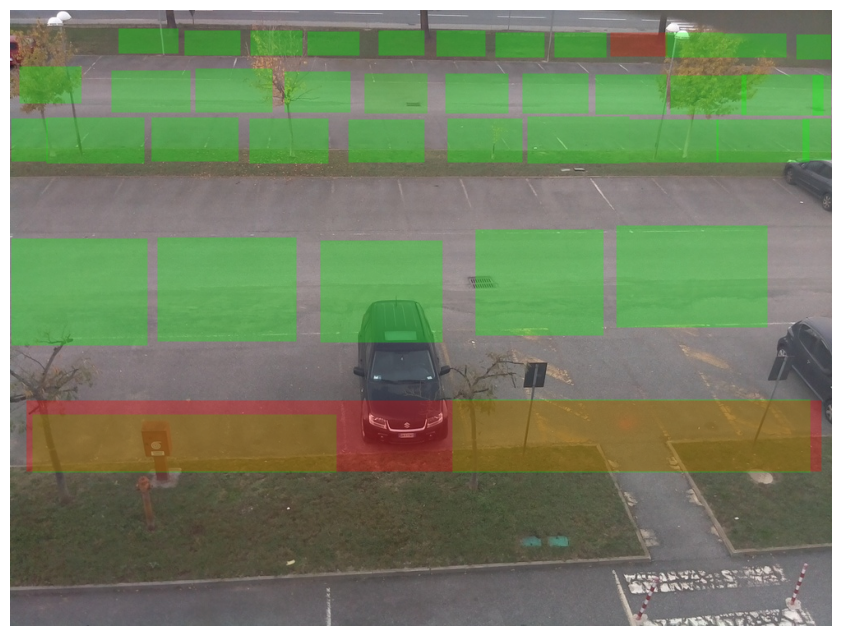

In [37]:
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision

# === CONFIG ===
IMAGE_PATH = "/content/parking_slots_image.png"
YOLO_BOXES_PATH = "/content/parking_slots.npy"

# === Helper: Convert YOLO box to quadrilateral ===
def box_to_normalized_yolo(box, img_w, img_h):
    x_min, y_min, x_max, y_max = box
    x_c = (x_min + x_max) / 2.0 / img_w
    y_c = (y_min + y_max) / 2.0 / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h
    return [x_c, y_c, w, h]

def yolo_to_quad(box):
    x_c, y_c, w, h = box
    x1 = x_c - w / 2
    y1 = y_c - h / 2
    x2 = x_c + w / 2
    y2 = y_c - h / 2
    x3 = x_c + w / 2
    y3 = y_c + h / 2
    x4 = x_c - w / 2
    y4 = y_c + h / 2
    return [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]

# === Load Image ===
image = torchvision.io.read_image(IMAGE_PATH)
# image_tensor = T.ToTensor()(image)
image_width, image_height = image.shape[1], image.shape[2]

# === Load and convert YOLO boxes ===
yolo_boxes = np.load(YOLO_BOXES_PATH)

normalized_yolo_boxes = [
    box_to_normalized_yolo(box, image_width, image_height)
    for box in yolo_boxes
]

converted_rois = torch.tensor([
    yolo_to_quad(box)
    for box in normalized_yolo_boxes
], dtype=torch.float32)   #[N, 4, 2]


# print(converted_rois)

# === Preprocess Image ===
# Convert back to PIL if needed and apply transforms
preprocessed_image = transforms.preprocess(image)  # from the repo
# preprocessed_image = preprocessed_image.unsqueeze(0)  # Add batch dim
# print(preprocessed_image[0])

# === Run Inference ===
with torch.no_grad():
    class_logits = model(preprocessed_image, converted_rois)  # model expects [C, H, W]
    class_scores = class_logits.softmax(1)[:, 1]  # class 1 = occupied

    print(class_scores.shape, converted_rois.shape)


print(*class_scores)

# === Visualization ===
# drawn_image = preprocessed_image.copy()
# draw = ImageDraw.Draw(drawn_image)
# font = ImageFont.load_default()

# for quad, score in zip(converted_rois, class_scores):
#     quad_np = np.array(quad.tolist(), dtype=np.int32)
#     draw.polygon(quad_np.flatten().tolist(), outline="red")
#     x1, y1 = quad_np[0]
#     draw.text((x1, y1 - 10), f"{score.item():.2f}", fill="red", font=font)

# plt.figure(figsize=(10, 10))
# plt.imshow(drawn_image)
# plt.axis("off")
# plt.title("Parking Occupancy Predictions")
# plt.show()
# vis.plot_ds_image(image, rois, labels, show=True)
# vis.plot_ds_image(preprocessed_image, converted_rois, class_scores)
